# Interest rates in a Huggett economy with naive hyperbolic discounters

*   Consumers have the utility function
    $$\mathcal{U}(c_t, c_{t+1}, \dots) = U(c_t) + \beta \mathrm{E}_t \sum_{s=0}^\infty \delta^s U(c_{t+s})$$
*   Consumers believe that in the future they will have the utility function
    $$\mathcal{U}(c_t, c_{t+1}, \dots) = U(c_t) + \hat\beta\mathrm{E}_t\sum_{s=0}^\infty \delta^s U(c_{t+s})$$
*   Consumers have an endowment in each period following a Markov-process
    $$ y_t \sim F(y_t|y_{t-1}) $$
*   Consumers have access to a riskless bond with borrowing limit $\underline{a}$ paying interest rate $r$

## Imports from the main file

In [1]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

from huggett_oner import (get_policy_functions,
                     excess_asset_demand,
                     get_excess_asset_demand,
                     get_eq_r,
                     get_eq_r_het,
                     get_asset_distribution,
                     paramfun,
                     paramfun3,
                     SHOCKS
                     )

%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context('talk')

## Constants

In [2]:
PARAMS = [[{'beta': beta,
            'betahat': betahat,
            'delta': 0.99,
            'gamma': 3,
            'Pi': np.array([[0.5, 0.075], [0.5, 0.925]]),
            'aBar': -2,
            'e': np.array([0.1, 1])
           }
           for betahat in np.arange(beta, 1.0001, 0.025)
          ]
          for beta in [0.6, 0.7, 0.8, 0.9, 1]
         ]

# Results

## Example consumption functions

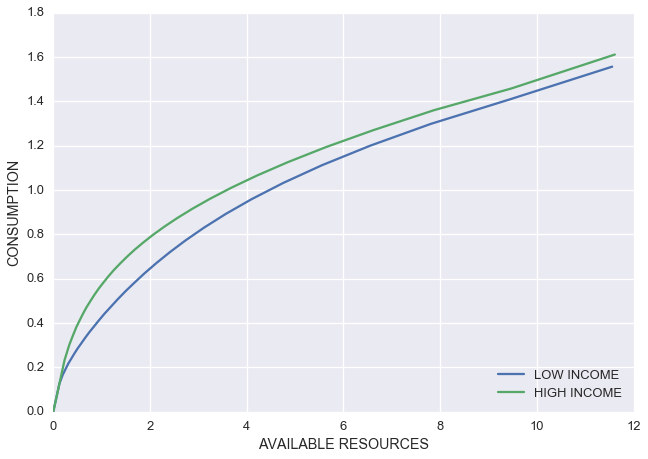

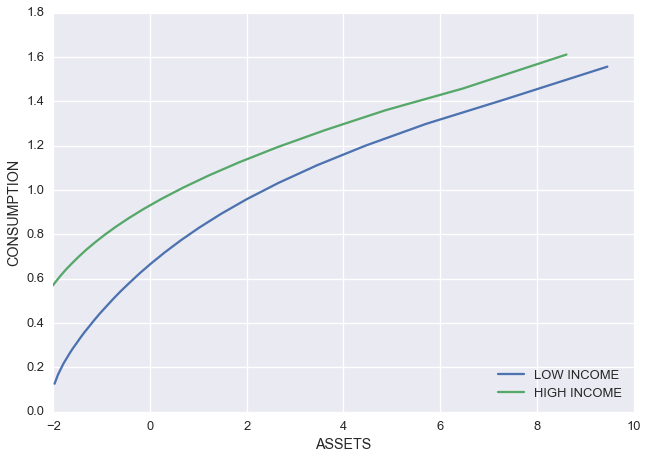

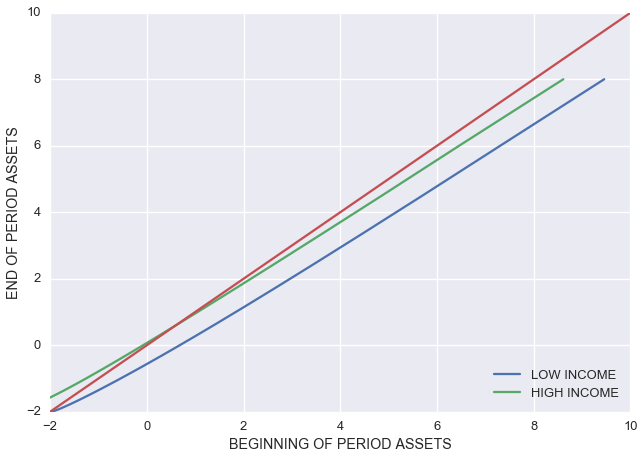

In [3]:
GRIDS = get_policy_functions(0, PARAMS[2][2])

plt.figure()
plt.plot(np.vstack((np.zeros((1, 2)), GRIDS['m'])),
         np.vstack((np.zeros((1, 2)), GRIDS['c']))
         )
plt.xlabel('AVAILABLE RESOURCES')
plt.ylabel('CONSUMPTION')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.show()

plt.figure()
plt.plot(GRIDS['s'],
         GRIDS['c']
         )
plt.xlabel('ASSETS')
plt.ylabel('CONSUMPTION')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.xlim((-2, 10))
plt.show()

plt.figure()
plt.plot(GRIDS['s'],
         np.transpose(np.tile(GRIDS['a'], (2,1)))
         )
plt.plot([-2, 10], [-2, 10])
plt.xlabel('BEGINNING OF PERIOD ASSETS')
plt.ylabel('END OF PERIOD ASSETS')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.xlim((-2, 10))
plt.show()

## Equilibrium interest rates

### Benchmark model

In [4]:
EQRS = []

for i in range(len(PARAMS)):
    with ProcessPoolExecutor(max_workers=8) as executor:
        RS = []
        for (p, r) in zip(PARAMS[i], executor.map(paramfun, PARAMS[i])):
            RS.append((p['beta'], p['betahat'], r[0]))
    executor.shutdown()
    EQRS.append(pd.DataFrame(RS,  columns=['beta', 'betahat', 'r']))

EQDF = pd.concat(EQRS)
EQDF.columns = ['beta', 'betahat', 'r']

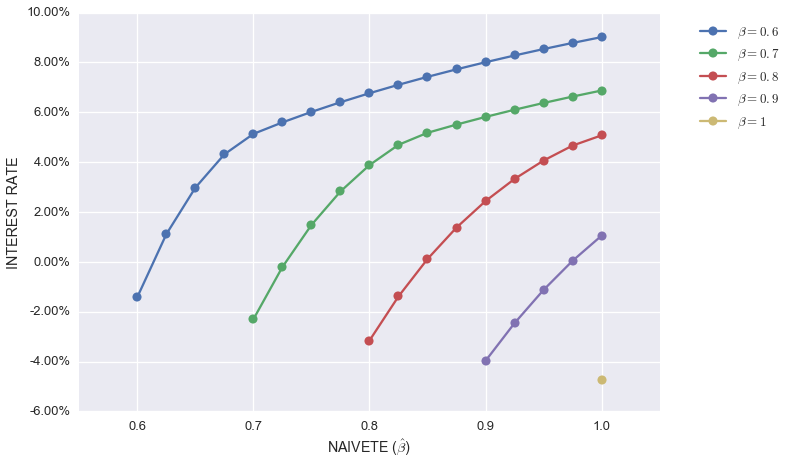

In [5]:
figr, axr = plt.subplots(1,1)
for df in EQRS:
    df.plot(x='betahat', y='r', ax=axr, marker='o')

axr.legend(['$\\beta = 0.6$',
            '$\\beta = 0.7$',
            '$\\beta = 0.8$',
            '$\\beta = 0.9$',
            '$\\beta = 1$'],
           bbox_to_anchor=(1.05, 1),
           loc=2
           )
axr.set_xlabel('NAIVETE ($\\hat\\beta$)')
axr.set_ylabel('INTEREST RATE')
axr.set_xlim([0.55, 1.05])
vals = axr.get_yticks()
axr.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()


### Lower income in the low state

In [6]:
PARAMS_le = [[{'beta': beta,
               'betahat': betahat,
               'delta': 0.99,
               'gamma': 3,
               'Pi': np.array([[0.5, 0.075], [0.5, 0.925]]),
               'aBar': -2,
               'e': np.array([0.05, 1])
              }
              for betahat in np.arange(beta, 1.0001, 0.025)
             ]
             for beta in [0.6, 0.7, 0.8, 0.9, 1]
            ]

In [7]:
EQRS_le = []

for i in range(len(PARAMS)):
    with ProcessPoolExecutor(max_workers=8) as executor:
        RS = []
        for (p, r) in zip(PARAMS_le[i], executor.map(paramfun, PARAMS_le[i])):
            RS.append((p['beta'], p['betahat'], r[0]))
    executor.shutdown()
    EQRS_le.append(pd.DataFrame(RS,  columns=['beta', 'betahat', 'r']))

EQDF_le = pd.concat(EQRS)
EQDF_le.columns = ['beta', 'betahat', 'r']

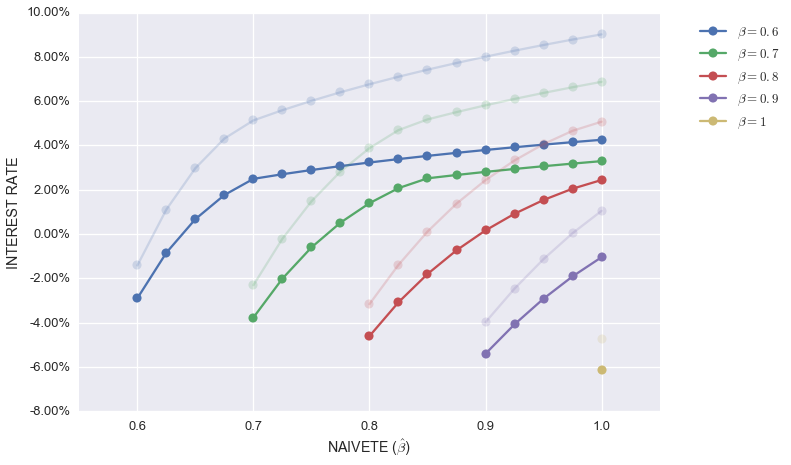

In [8]:
figr, axrle = plt.subplots(1,1)
palette = itertools.cycle(sns.color_palette())
for df in EQRS_le:
    df.dropna().plot(x='betahat', y='r', ax=axrle, marker='o', color=next(palette))
palette = itertools.cycle(sns.color_palette())
for df in EQRS:
    df.dropna().plot(x='betahat', y='r', ax=axrle, marker='o', alpha=0.2, color=next(palette))

axrle.legend(['$\\beta = 0.6$',
              '$\\beta = 0.7$',
              '$\\beta = 0.8$',
              '$\\beta = 0.9$',
              '$\\beta = 1$'],
             bbox_to_anchor=(1.05, 1),
             loc=2
             )
axrle.set_xlabel('NAIVETE ($\\hat\\beta$)')
axrle.set_ylabel('INTEREST RATE')
axrle.set_xlim([0.55, 1.05])
vals = axrle.get_yticks()
axrle.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

### Higher income in the low state

In [9]:
PARAMS_he = [[{'beta': beta,
               'betahat': betahat,
               'delta': 0.99,
               'gamma': 3,
               'Pi': np.array([[0.5, 0.075], [0.5, 0.925]]),
               'aBar': -2,
               'e': np.array([0.2, 1])
              }
              for betahat in np.arange(beta, 1.0001, 0.025)
             ]
             for beta in [0.6, 0.7, 0.8, 0.9, 1]
            ]

In [10]:
EQRS_he = []

for i in range(len(PARAMS_he)):
    with ProcessPoolExecutor(max_workers=8) as executor:
        RS = []
        for (p, r) in zip(PARAMS_he[i], executor.map(paramfun, PARAMS_he[i])):
            RS.append((p['beta'], p['betahat'], r[0]))
    executor.shutdown()
    EQRS_he.append(pd.DataFrame(RS,  columns=['beta', 'betahat', 'r']))

EQDF_he = pd.concat(EQRS)
EQDF_he.columns = ['beta', 'betahat', 'r']

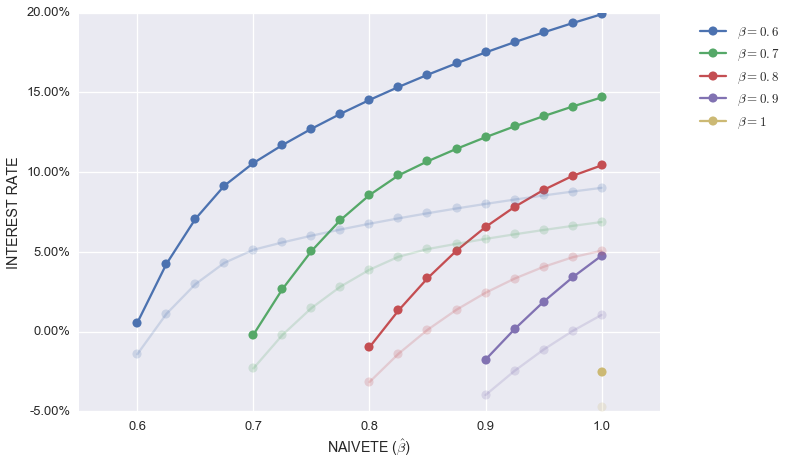

In [11]:
figrhe, axrhe = plt.subplots(1,1)
palette = itertools.cycle(sns.color_palette())
for df in EQRS_he:
    df.dropna().plot(x='betahat', y='r', ax=axrhe, marker='o', color=next(palette))
palette = itertools.cycle(sns.color_palette())
for df in EQRS:
    df.dropna().plot(x='betahat', y='r', ax=axrhe, marker='o', color=next(palette), alpha=0.2)

axrhe.legend(['$\\beta = 0.6$',
              '$\\beta = 0.7$',
              '$\\beta = 0.8$',
              '$\\beta = 0.9$',
              '$\\beta = 1$'],
             bbox_to_anchor=(1.05, 1),
             loc=2
             )
axrhe.set_xlabel('NAIVETE ($\\hat\\beta$)')
axrhe.set_ylabel('INTEREST RATE')
axrhe.set_xlim([0.55, 1.05])
vals = axrhe.get_yticks()
axrhe.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

### Lending rates with 1% borrowing interest rate

In [12]:
# def paramfilter(par):
#     return EQDF[np.logical_and(EQDF['beta'] == par['beta'],
#                                EQDF['betahat'] == par['betahat'])
#                ].r.iloc[0] > 0.01

# PARAMS2 = [list(filter(paramfilter, paramset)) for  paramset in PARAMS]
# PARAMS2 = [p for p in PARAMS2 if p != []]

In [13]:
# EQRLS = []

# for i in range(len(PARAMS2)):
#     with ProcessPoolExecutor(max_workers=8) as executor:
#         RS = []
#         for (p, rl) in zip(PARAMS2[i], executor.map(paramfun2, PARAMS2[i])):
#             RS.append((p['beta'], p['betahat'], rl[0]))
#     executor.shutdown()
#     EQRLS.append(pd.DataFrame(RS, columns=['beta', 'betahat', 'rl']))

# EQDF_L = pd.concat(EQRLS)
# EQDF_L.columns = ['beta', 'betahat', 'rl']

In [14]:
# figrl, axrl = plt.subplots(1,1)
# palette = itertools.cycle(sns.color_palette())
# for df in EQRLS:
#     df.dropna().plot(x='betahat', y='rl', ax=axrl, marker='o', color=next(palette))
# palette = itertools.cycle(sns.color_palette())
# for df in EQRS:
#     df.dropna().plot(x='betahat', y='r', ax=axrl, alpha=0.3, marker='o', color=next(palette))

# axrl.legend(['$\\beta = 0.6$',
#             '$\\beta = 0.7$',
#             '$\\beta = 0.8$',
#             '$\\beta = 0.9$',
#             '$\\beta = 1$'][0:len(PARAMS2)], 
#            bbox_to_anchor=(1.05, 1),
#            loc=2
#            )
# axrl.set_xlabel('NAIVETE ($\\hat\\beta$)')
# axrl.set_ylabel('INTEREST RATE')
# axrl.set_xlim([0.55, 1.05])
# vals = axrl.get_yticks()
# axrl.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
# plt.show()

### Higher income in the low state, borrowing rate at 1%

In [15]:
# def paramfilter_he(par):
#     return EQDF_he[np.logical_and(EQDF_he['beta'] == par['beta'],
#                                   EQDF_he['betahat'] == par['betahat'])
#                   ].r.iloc[0] > 0.01

# PARAMS2_he = [list(filter(paramfilter_he, paramset)) for  paramset in PARAMS_he]
# PARAMS2_he = [p for p in PARAMS2_he if p != []]

In [16]:
# EQRLS_he = []

# for i in range(len(PARAMS2)):
#     with ProcessPoolExecutor(max_workers=8) as executor:
#         RS = []
#         for (p, rl) in zip(PARAMS2_he[i], executor.map(paramfun2, PARAMS2_he[i])):
#             RS.append((p['beta'], p['betahat'], rl[0]))
#     executor.shutdown()
#     EQRLS_he.append(pd.DataFrame(RS, columns=['beta', 'betahat', 'rl']))

# EQDF_Lhe = pd.concat(EQRLS)
# EQDF_Lhe.columns = ['beta', 'betahat', 'rl']

In [17]:
# figrlhe, axrlhe = plt.subplots(1,1)
# palette = itertools.cycle(sns.color_palette())
# for df in EQRLS_he:
#     df.dropna().plot(x='betahat', y='rl', ax=axrlhe, marker='o', color=next(palette))
# palette = itertools.cycle(sns.color_palette())
# for df in EQRS_he:
#     df.dropna().plot(x='betahat', y='r', ax=axrlhe, alpha=0.3, marker='o', color=next(palette))

# axrlhe.legend(['$\\beta = 0.6$',
#             '$\\beta = 0.7$',
#             '$\\beta = 0.8$',
#             '$\\beta = 0.9$',
#             '$\\beta = 1$'][0:len(PARAMS2_he)], 
#            bbox_to_anchor=(1.05, 1),
#            loc=2
#            )
# axrlhe.set_xlabel('NAIVETE ($\\hat\\beta$)')
# axrlhe.set_ylabel('INTEREST RATE')
# axrlhe.set_xlim([0.55, 1.05])
# vals = axrlhe.get_yticks()
# axrlhe.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
# plt.show()

## Heterogenous population

### Heterogeneity in the hyperbolic discount factor

In [60]:
het_in_beta = [(0.2, PARAMS[1][-1]), (0.8, PARAMS[-1][-1])]
r_hetbeta = get_eq_r_het(het_in_beta, SHOCKS)
dist_hetbeta_exp = get_asset_distribution(r_hetbeta, PARAMS[-1][-1], SHOCKS)
dist_hetbeta_hyp = get_asset_distribution(r_hetbeta, PARAMS[1][-1], SHOCKS)

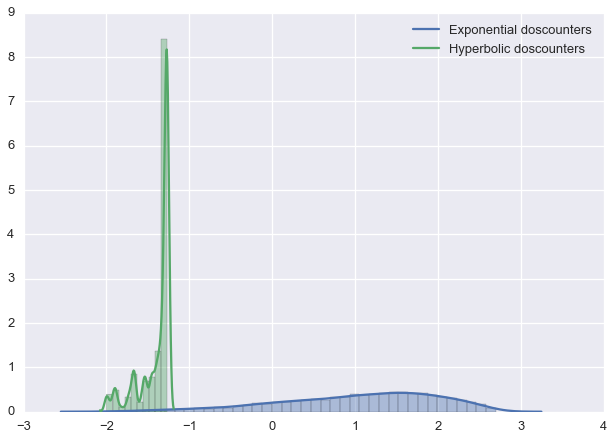

In [61]:
fighetbeta, axhetbeta = plt.subplots(1, 1)
sns.distplot(dist_hetbeta_exp, bins=40, ax=axhetbeta, kde_kws={'label': 'Exponential doscounters'})
sns.distplot(dist_hetbeta_hyp, bins=10, ax=axhetbeta, kde_kws={'label': 'Hyperbolic doscounters'})

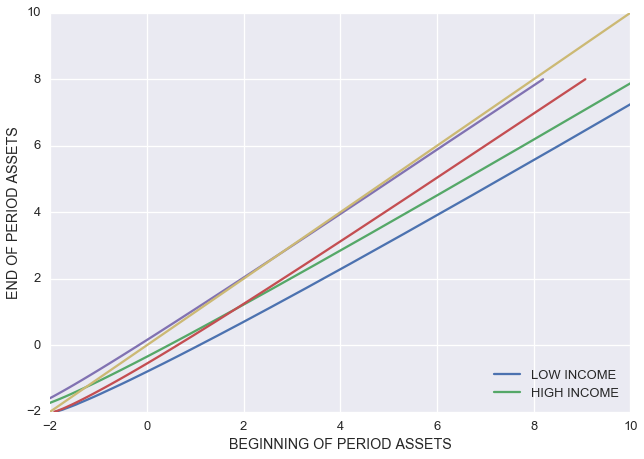

In [65]:
GRIDCHECK = get_policy_functions(r_hetbeta, PARAMS[1][-1])
GRIDCHECK2 = get_policy_functions(r_hetbeta, PARAMS[-1][-1])
plt.figure()
plt.plot(GRIDCHECK['s'],
         np.transpose(np.tile(GRIDCHECK['a'], (2,1)))
         )
plt.plot(GRIDCHECK2['s'],
         np.transpose(np.tile(GRIDCHECK['a'], (2,1)))
         )
plt.plot([-2, 10], [-2, 10])
plt.xlabel('BEGINNING OF PERIOD ASSETS')
plt.ylabel('END OF PERIOD ASSETS')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.xlim((-2, 10))
plt.show()

### Heterogeneity in naivete

In [20]:
het_in_betahat = [(0.2, PARAMS[1][-1]), (0.8, PARAMS[1][0])]
r_hetbetahat = get_eq_r_het(het_in_betahat, SHOCKS)
dist_hetbeta_sop = get_asset_distribution(r_hetbetahat, PARAMS[1][0], SHOCKS)
dist_hetbeta_nai = get_asset_distribution(r_hetbetahat, PARAMS[1][-1], SHOCKS)

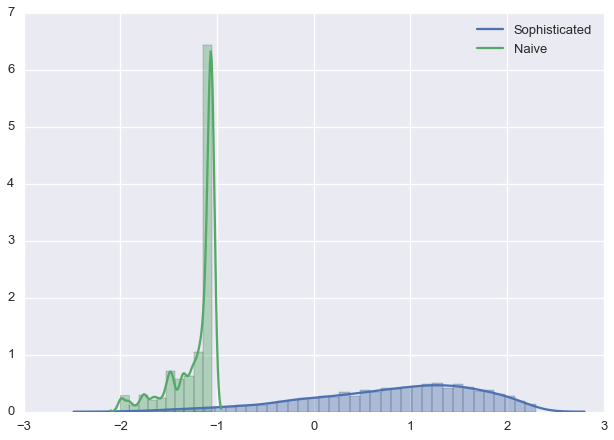

In [55]:
fighetbetahat, axhetbetahat = plt.subplots(1, 1)
sns.distplot(dist_hetbeta_sop, bins=40, ax=axhetbetahat, kde_kws={'label': 'Sophisticated'})
sns.distplot(dist_hetbeta_nai, bins=10, ax=axhetbetahat, kde_kws={'label': 'Naive'})